In [5]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits import mplot3d
from sklearn.model_selection import KFold
import math

%matplotlib inline
plt.style.use('seaborn-white')

# Lasso Overview

Least Absolute Shrinkage and Selection Operator

Objective Function:

$$ \begin{eqnarray}
\underset{\beta}{\mathrm{argmin}} RSS_{lasso} (\beta) &=& \frac{1}{2}RSS_{OLS} (\beta) + \lambda |\beta|_{1}\\
&=& \underset{\beta}{\mathrm{argmin}} \frac{1}{2} ||y - (\beta)X)||^{2}_{2} + \lambda |\beta|_{1} \\ 
&=& f(\beta) + g(\beta)
\end{eqnarray}$$

where $f(\beta)$ is the $RSS_{OLS}$ term, and $g(\beta)$ is the regularization factor for Lasso.

After applying some subdifferentials and subderivatives, we find that the Objective function becomes: 

$$ \begin{eqnarray}
\frac{\partial d}{\partial d \beta_{j}} RSS_{Lasso} + \partial \beta_{j} \lambda \sum^{n}_{j=0} |\beta_{j}|
&=& - \sum^{m}_{i=0} x_{j}^{i} (y^{i} - \sum^{n}_{k \ne j} \theta_{k} x_{k}^{i} ) + \theta_{j} \sum^{m}_{i=1} (x_{j}^{i})^{2} + \partial_{\beta_{j}} \lambda|\beta_{j}| \\ 
&=& - \rho_{j} +  \beta_{j} z + \partial_{\beta_{j}} \lambda|\beta_{j}| \\
\end{eqnarray}$$

SR3: Sparse Relaxed Regularized Regression 
    - Better numerical properties. Relaxed coordinates.

Proposed strategy:
- Use Soft-thresholding operator using coordinate descent algorithms
- Tuning lambda:
    - Define a range of lambda values.
    - 10-fold Cross validation-- partition training set into 10 sets. Fit 10 lasso models for each lamda value. 
    - Obtain MAE of lasso models for all 10 models for $\lambda = k$.
    - Find mean MAE for each lambda=k.
    - Find lambda value with minimum mean MAE.

Notes on Lasso:

Video 2: Steve Brunton from UW

- For variable selection and getting interpretable regression models that don't overfit to data.
- Feature selection: 
    - LASSO can provide a sparse solution $\overrightarrow{\beta}$-- hence feature selection.

- Attributes:
    - Interpretability:
        - OLS is not interpretable because all variables are considered important. Lasso selects important variables.
        - Lower dimensional models (if similarly good at minimizing error), is easier to interpret, communicate and make decisions. (principle of parsimony).
    - Prevents overfitting:
        - OLS: x coefficients may overfit A to data in b. (modelling noise and reducing generalizability)
        - When $\lambda$ increases past $\lambda_{lasso}$, MSE starts increasing again because we are adding in terms that are collinear and not actually correlated with response variable. 
    - Multicollinearity:
        - When variables are collinear, OLS amplifies noise in response vector (nearly linearly dependent).

- Geometric Visualization:
    - L1 norm intersects space of all possible solutions at a sparse solution. L1 norm intersects at a dense solution. 

### Lasso from scratch begins here: 

1. The setup: design matrix and response variable (price).
2. Two functions: soft_thresholding and coordinate_descent_lasso are created. 
    - soft_thresholding: returns value of $\beta$ objective function based on values of rho and lamda. There are three cases ($\rho > lambda$, $\rho < -\lambda$, $-\lambda \le \rho \le \lambda$) that influence coordinate descent lasso solution.  
    - coordinate_descent_lasso: returns lasso solution vector: $\beta$.

In [7]:
#Loading in Data
df = pd.read_csv("../data/listings.csv")

In [8]:
df.drop(df.columns[0], axis=1, inplace=True)

In [9]:
np.shape(df) # ORIGINAL DATASET: 38837 x 232 

(38837, 233)

In [10]:
# 32 predictor dataset: 
X_df = df[
    [
        "minimum_nights",
        "number_of_reviews",
        "reviews_per_month",
        "calculated_host_listings_count",
        "availability_365",
        "neighbourhood_group_Bronx",
        "neighbourhood_group_Brooklyn",
        "neighbourhood_group_Manhattan",
        "neighbourhood_group_Queens",
        "neighbourhood_group_Staten Island",
        "neighbourhood_Midtown",
        "neighbourhood_Lower East Side",
        "neighbourhood_Harlem",
        "neighbourhood_Upper East Side",
        "neighbourhood_Upper West Side",
        "neighbourhood_Washington Heights",
        "neighbourhood_East Harlem",
        "neighbourhood_Chinatown",
        "neighbourhood_East Village",
        "neighbourhood_Financial District",
        "neighbourhood_Morningside Heights",
        "neighbourhood_Inwood",
        "neighbourhood_Hell's Kitchen",
        "neighbourhood_Battery Park City",
        "neighbourhood_Chelsea",
        "neighbourhood_Two Bridges",
        "neighbourhood_Gramercy",
        "neighbourhood_NoHo",
        "neighbourhood_Greenwich Village",
        "neighbourhood_SoHo",
        "room_type_Entire home/apt",
        "room_type_Private room"
    ]
]
X = X_df.to_numpy()
y_df = df[["price"]]
y = y_df.to_numpy()

In [11]:
np.shape(X) # SUBSETTED DATASET: 38837 X 32

(38837, 32)

In [12]:
# Creating train and test sets: 20% testing (7768), 80% training (31069)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=200)

In [13]:
def soft_threshold(rho,lamda):
    '''Soft threshold function used for normalized data and lasso regression'''
    if rho < - lamda:
        return (rho + lamda)
    elif rho >  lamda:
        return (rho - lamda)
    else: 
        return 0

In [10]:
def coordinate_descent_lasso(theta,X,y,lamda = .01, num_iters=100, intercept = False):
    '''Coordinate gradient descent for lasso regression - for normalized data. 
    The intercept parameter allows to specify whether or not we regularize theta_0'''
    
    #Initialisation of useful values 
    m,n = X.shape
    X = X / (np.linalg.norm(X,axis = 0)) #normalizing X in case it was not done before
    
    #Looping until max number of iterations
    for i in range(num_iters): 
        
        #Looping through each coordinate
        for j in range(n):
            
            #Vectorized implementation
            X_j = X[:,j].reshape(-1,1)
            y_pred = X @ theta
            rho = X_j.T @ (y - y_pred  + theta[j]*X_j)
        
            #Checking intercept parameter
            if intercept == True:  
                if j == 0: 
                    theta[j] =  rho 
                else:
                    theta[j] =  soft_threshold(rho, lamda)  

            if intercept == False:
                theta[j] =  soft_threshold(rho, lamda)   
            
    return theta.flatten()

In [12]:
cols = list(X_df.columns)

In [13]:
np.shape(X_train)

(31069, 32)

In [14]:
cols

['minimum_nights',
 'number_of_reviews',
 'reviews_per_month',
 'calculated_host_listings_count',
 'availability_365',
 'neighbourhood_group_Bronx',
 'neighbourhood_group_Brooklyn',
 'neighbourhood_group_Manhattan',
 'neighbourhood_group_Queens',
 'neighbourhood_group_Staten Island',
 'neighbourhood_Midtown',
 'neighbourhood_Lower East Side',
 'neighbourhood_Harlem',
 'neighbourhood_Upper East Side',
 'neighbourhood_Upper West Side',
 'neighbourhood_Washington Heights',
 'neighbourhood_East Harlem',
 'neighbourhood_Chinatown',
 'neighbourhood_East Village',
 'neighbourhood_Financial District',
 'neighbourhood_Morningside Heights',
 'neighbourhood_Inwood',
 "neighbourhood_Hell's Kitchen",
 'neighbourhood_Battery Park City',
 'neighbourhood_Chelsea',
 'neighbourhood_Two Bridges',
 'neighbourhood_Gramercy',
 'neighbourhood_NoHo',
 'neighbourhood_Greenwich Village',
 'neighbourhood_SoHo',
 'room_type_Entire home/apt',
 'room_type_Private room']

### Fitting Lasso: (No intercept)

In [111]:
# Initialize variables
m,n = X_train.shape
initial_theta = np.ones((n,1))
theta_list = list()
lamda = np.logspace(0,7,300)/10 #Range of lambda values

#Run lasso regression for each lambda
for l in lamda:
    theta = coordinate_descent_lasso(initial_theta,X_train,y_train,lamda = l, num_iters=100)
    theta_list.append(theta)

#Stack into numpy array
theta_lasso = np.stack(theta_list).T

(0.0446683592150963, 2238721.138568338, -4682.581412085356, 18211.16813206005)

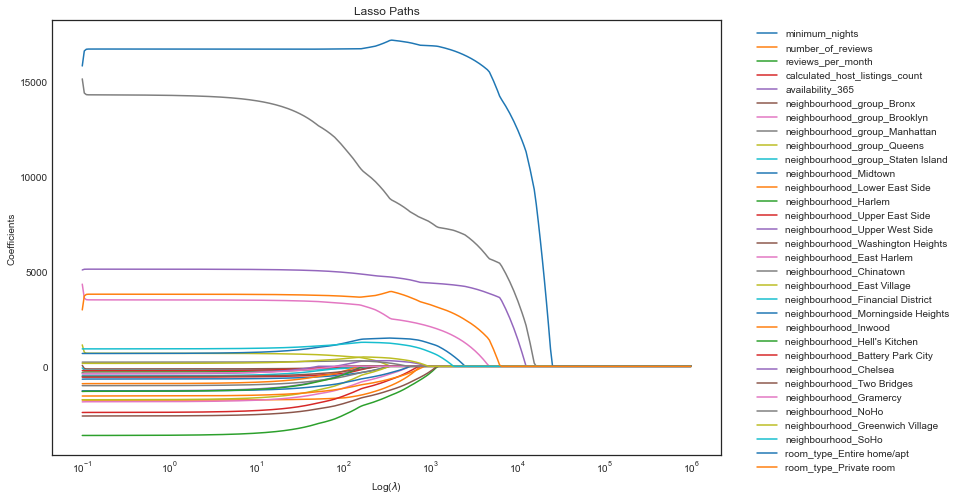

In [112]:
#Plot results
n,_ = theta_lasso.shape
plt.figure(figsize = (12,8))

for i in range(n):
    plt.plot(lamda, theta_lasso[i], label = cols[i])

plt.xscale('log')
plt.xlabel('Log($\\lambda$)')
plt.ylabel('Coefficients')
plt.title('Lasso Paths')
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.axis('tight')

In [127]:
def lambda_tune(X_train,y_train, intercept):
    
    all_mae = list() # 300 total entries (lambda), each entry has 10 entries (10-fold)
    all_mse = list() # 300 total entries (lambda), each entry has 10 entries (10-fold)
    lamda = np.logspace(0,7,300)/10 #Range of lambda values
    
    kf = KFold(n_splits = 10, random_state = True, shuffle = True)

    for l in lamda:                                             # Iterate through all lambda (200)
        mae_vals = list()                                       # list of MAE values for each lambda. Resets for each lambda
        mse_vals = list()
        
        for train_index, test_index in kf.split(X_train):       # Iterate through each of 10 folds for each lamda 
            temp_X_train = X_train[train_index]
            temp_y_train = y_train[train_index]
            temp_X_test = X_train[test_index]
            temp_y_test = y_train[test_index]
            
            n,p = temp_X_train.shape
            initial_theta = np.ones((p,1))
            MAE = 0
            MSE = 0
            
            if intercept == True:
                theta = coordinate_descent_lasso(initial_theta,temp_X_train,temp_y_train,lamda = l, num_iters=100, intercept = True) # fit lasso model
                y_pred = temp_X_test @ theta                         # Predicted response values based on beta coefficients
            else:
                theta = coordinate_descent_lasso(initial_theta,temp_X_train,temp_y_train,lamda = l, num_iters=100) # fit lasso model
                y_pred = temp_X_test @ theta                         # Predicted response values based on beta coefficients                
            for i in range(len(test_index)):
                MAE += abs(temp_y_test[i][0] - y_pred[i])
                MSE += (temp_y_test[i][0] - y_pred[i])**2
            MAE = MAE/n                                         # MAE of each lasso model (10) for each lambda (300)
            MSE = MSE/n                                         # MSE of each lasso model (10) for each lambda (300) 
            mae_vals.append(MAE)
            mse_vals.append(MSE)
        all_mae.append(mae_vals)                                # Appending 10 MAE values from 10 fitted lasso models
        all_mse.append(mse_vals)
    return all_mae, all_mse,lamda

In [128]:
all_mae, all_mse, lamda = lambda_tune(X_train,y_train, intercept = False)

No handles with labels found to put in legend.


(0.0446683592150963,
 2238721.138568338,
 -174.70674802088823,
 4006.7976486432162)

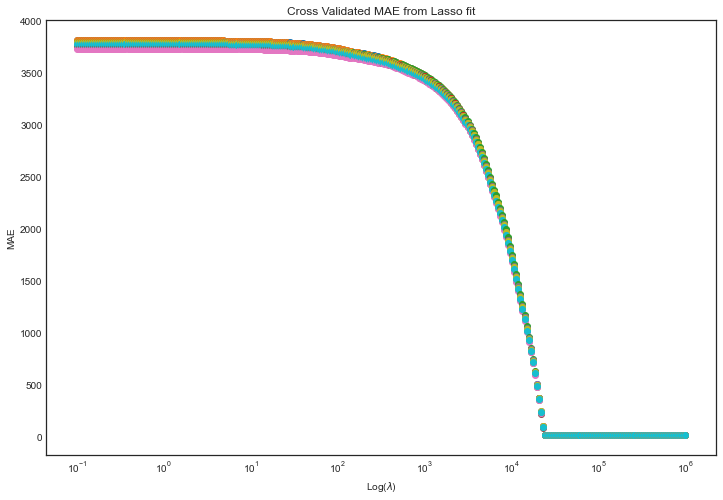

In [129]:
# Plotting MAE against lamda (model without intercept)

n = 300
plt.figure(figsize = (12,8))

for i in range(n):
    for j in range(10):
        plt.scatter(lamda[i], all_mae[i][j])

plt.xscale('log')
plt.xlabel('Log($\\lambda$)')
plt.ylabel('MAE')
plt.title('Cross Validated MAE from Lasso fit')
plt.legend()
plt.axis('tight')

In [130]:
# Finding the minimum lamda value
allmeans = list()
for i in range(300):
    allmeans.append(np.mean(all_mae[i]))

min_index = allmeans.index(min(allmeans))
lamda[min_index]

24244.62017082326

No handles with labels found to put in legend.


(0.0446683592150963, 2238721.138568338, -8202436.547595174, 172348424.9393098)

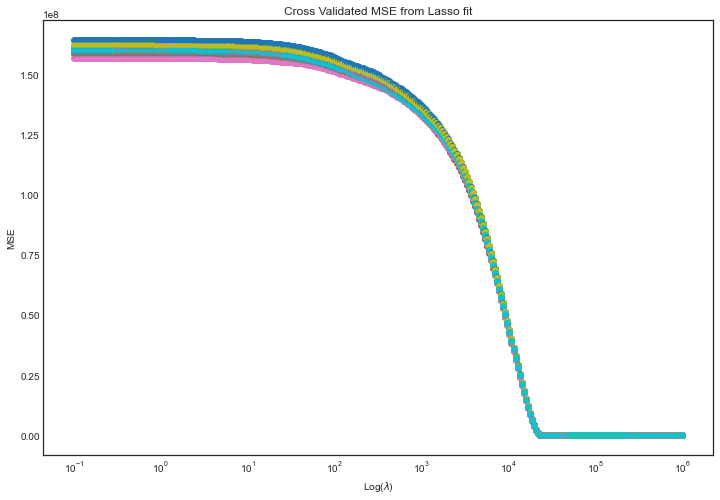

In [132]:
# Plotting MSE against lamda (model w/ intercept)

n = 300
plt.figure(figsize = (12,8))

for i in range(n):
    for j in range(10):
        plt.scatter(lamda[i], all_mse[i][j])

plt.xscale('log')
plt.xlabel('Log($\\lambda$)')
plt.ylabel('MSE')
plt.title('Cross Validated MSE from Lasso fit')
plt.legend()
plt.axis('tight')

In [134]:
# Finding the minimum lamda value
allmeans = list()
for i in range(300):
    allmeans.append(np.mean(all_mse[i]))

min_index = allmeans.index(min(allmeans))
lamda[min_index]

24244.62017082326

### Implementation using sklearn (for comparison)

In [205]:
from sklearn import linear_model

# Fitting lasso model with lambda = 24244
#clf = linear_model.Lasso(alpha=16, fit_intercept = False)
#clf.fit(X_train,y_train)
#clf.coef_

In [206]:
# Initialize variables
m,n = X_train.shape
theta_list_sk = list()
lamda = np.logspace(0,4,300)/10 #Range of lambda values

#Run lasso regression for each lambda
for l in lamda:
    clf = linear_model.Lasso(alpha = l, fit_intercept = False)
    clf.fit(X_train,y_train)
    theta_list_sk.append(clf.coef_)

#Stack into numpy array
theta_lasso_sk = np.stack(theta_list_sk).T

(0.06309573444801933,
 1584.893192461114,
 -23.362796399911158,
 73.22720523421583)

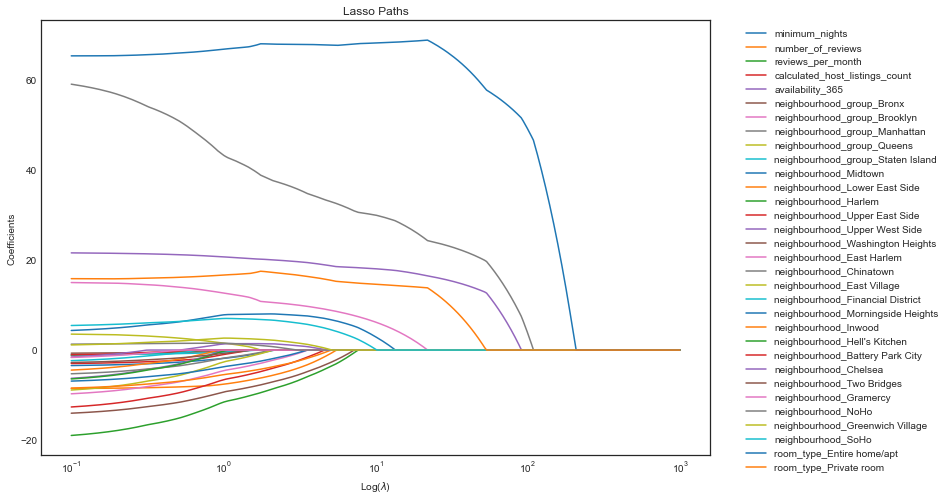

In [207]:
# SK_Lasso Path

#Plot results
n,_ = theta_lasso_sk.shape
plt.figure(figsize = (12,8))

for i in range(n):
    plt.plot(lamda, theta_lasso_sk[i], label = cols[i])

plt.xscale('log')
plt.xlabel('Log($\\lambda$)')
plt.ylabel('Coefficients')
plt.title('Lasso Paths')
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.axis('tight')

In [2]:
def lambda_tune_SK(X_train,y_train):
    
    all_mae = list() # 300 total entries (lambda), each entry has 10 entries (10-fold)
    all_mse = list() # 300 total entries (lambda), each entry has 10 entries (10-fold)
    lamda = np.logspace(0,7,300)/10 #Range of lambda values
    
    kf = KFold(n_splits = 10, random_state = True, shuffle = True)

    for l in lamda:                                             # Iterate through all lambda (200)
        mae_vals = list()                                       # list of MAE values for each lambda. Resets for each lambda
        mse_vals = list()
        
        for train_index, test_index in kf.split(X_train):       # Iterate through each of 10 folds for each lamda 
            temp_X_train = X_train[train_index]
            temp_y_train = y_train[train_index]
            temp_X_test = X_train[test_index]
            temp_y_test = y_train[test_index]
            
            MAE = 0
            MSE = 0
            
            clf = linear_model.Lasso(alpha= l , fit_intercept = False)
            clf.fit(temp_X_train,temp_y_train)
            
            y_pred = temp_X_test @ clf.coef_                     # Predicted response values based on beta coefficients                
            for i in range(len(test_index)):
                MAE += abs(temp_y_test[i][0] - y_pred[i])
                MSE += (temp_y_test[i][0] - y_pred[i])**2
            MAE = MAE/n                                         # MAE of each lasso model (10) for each lambda (300)
            MSE = MSE/n                                         # MSE of each lasso model (10) for each lambda (300) 
            mae_vals.append(MAE)
            mse_vals.append(MSE)
        all_mae.append(mae_vals)                                # Appending 10 MAE values from 10 fitted lasso models
        all_mse.append(mse_vals)
    return all_mae, all_mse,lamda

In [3]:
all_mae_sk, all_mse_sk, lamda = lambda_tune_SK(X_train,y_train)

NameError: name 'X_train' is not defined

No handles with labels found to put in legend.


(0.0446683592150963, 2238721.138568338, 5037.533990948182, 14849.171000431039)

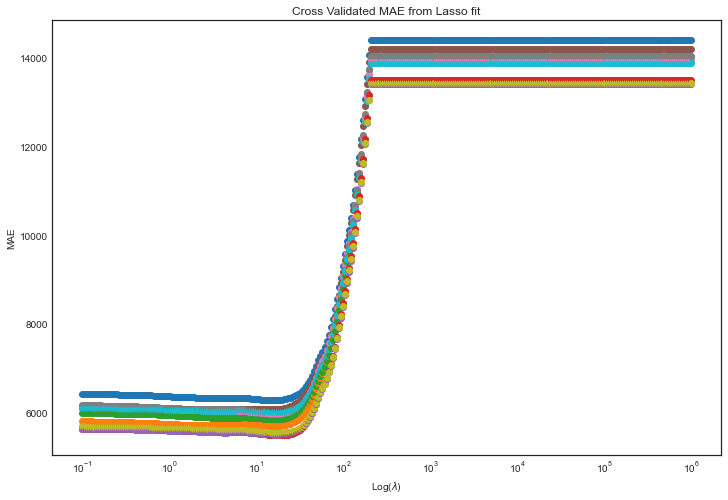

In [160]:
# 10-fold CV: Plotting MAE against lamda (sk-lasso model)

n = 300
plt.figure(figsize = (12,8))

for i in range(n):
    for j in range(10):
        plt.scatter(lamda[i], all_mae_sk[i][j])

plt.xscale('log')
plt.xlabel('Log($\\lambda$)')
plt.ylabel('MAE')
plt.title('Cross Validated MAE from Lasso fit')
plt.legend()
plt.axis('tight')

In [1]:
import plotly.express as px
from IPython.display import display

display(MAE)

NameError: name 'MAE' is not defined

In [163]:
# Finding the minimum lamda value
allmeans = list()
for i in range(300):
    allmeans.append(np.mean(all_mae_sk[i]))

min_index = allmeans.index(min(allmeans))
lamda[min_index]

16.75252472408214

No handles with labels found to put in legend.


(0.06309573444801933, 1584.893192461114, 1190355.6067298301, 8768245.64075096)

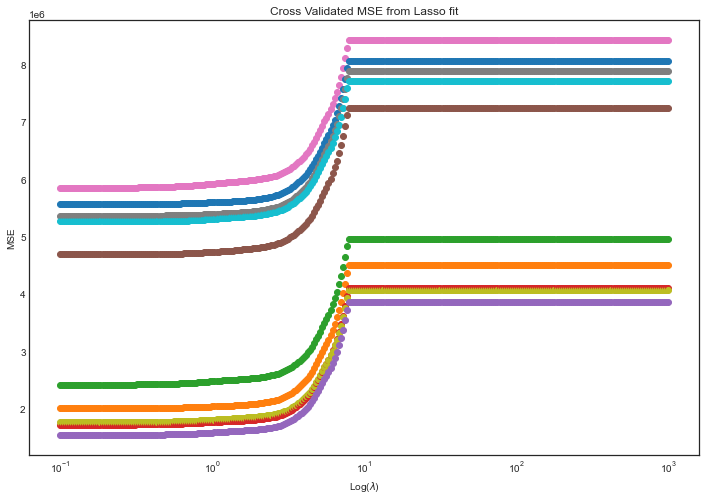

In [208]:
# Plotting MSE against lamda (sk-lasso model)

n = 300
plt.figure(figsize = (12,8))

for i in range(n):
    for j in range(10):
        plt.scatter(lamda[i], all_mse_sk[i][j])

plt.xscale('log')
plt.xlabel('Log($\\lambda$)')
plt.ylabel('MSE')
plt.title('Cross Validated MSE from Lasso fit')
plt.legend()
plt.axis('tight')

In [164]:
# Finding the minimum lamda value
allmeans = list()
for i in range(300):
    allmeans.append(np.mean(all_mse_sk[i]))

min_index = allmeans.index(min(allmeans))
lamda[min_index]

0.1

In [146]:
# [FROM SCRATCH] Tuned hyperparameter model:

# Initialize variables
m,n = X_train.shape
initial_theta = np.ones((n,1))

#Run lasso regression for tuned lambda
theta = coordinate_descent_lasso(initial_theta,X_train,y_train,lamda = 24244, num_iters=300)
theta

array([  0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        , 909.26194755,   0.        ])

## Generating final model 
- Recap: 
    - Hyperparameter tuning: 
        - Coordinate_descent: lambda = 24244 (minimum MSE & minimum MAE) 
        - Sk_lasso: lambda = 16.75252472408214 (MAE), lambda = 0.1 (MSE)
    - Lasso model without intercept is chosen because of strange lasso path that has increasing beta value.
    
 - SK_Lasso Model: 5 variables: 
     - availability_365, 'neighbourhood_group_Brooklyn', 'neighbourhood_group_Manhattan', 'room_type_Entire home/apt', 'room_type_Private room'.
     - $$y = 17.21323117 X_{availability_365} + 2.6954145 X_{neighbourhood_group_Brooklyn} + 27.00013305 X_{neighbourhood_group_Manhattan} + 68.55946047 X_{room_type_Entire home/apt} + 14.12280336 X_{room_type_Private room} + \epsilon$$ with $\epsilon$: noise term, and $\lambda = 16.75252472408214$ tuned from minimium MAE
 - Coordinate_descent Model: 1 variable: 
     - $y = 909.26194755 X_{room_type_Private room} + \epsilon$ with $\lambda = 24244$

In [14]:
clf = linear_model.Lasso(alpha= 16.75252472408214 , fit_intercept = False)
clf.fit(X_train,y_train)
clf.coef_

NameError: name 'linear_model' is not defined

In [181]:
#cols[4] # availability_365
#cols[6] # 'neighbourhood_group_Brooklyn'
#cols[7] # 'neighbourhood_group_Manhattan'
#cols[30] # 'room_type_Entire home/apt'
#cols[31] # 'room_type_Private room'

'room_type_Private room'

In [216]:
# Testing MSE of model against testing data:
import timeit
timestart = timeit.default_timer()           # start timer
clf = linear_model.Lasso(alpha= 16.75252472408214 , fit_intercept = False)
clf.fit(X_train,y_train)
timeend = timeit.default_timer()             # end timer
time_elapsed = (timeend - timestart) # calculate elapsed time

y_pred = X_test@clf.coef_
y_pred
MSE = 0
MAE = 0
n = len(y_test)
for i in range(n):
    MSE += (y_test[i][0] - y_pred[i])**2
    MAE += abs(y_test[i][0] - y_pred[i])
MSE = MSE/n
MAE = MAE/n

In [217]:
print("The MSE of our Lasso model is: ",MSE)
print("The MAE of our Lasso model is: ",MAE)
print("The training run-time for our Lasso model is: ",time_elapsed)

The MSE of our Lasso model is:  8517915.669298718
The MAE of our Lasso model is:  1933.9078181510783
The training run-time for our Lasso model is:  0.04226710001239553


In [220]:
import numpy
 
corr_matrix = numpy.corrcoef(y_test[:,0], y_pred)
corr = corr_matrix[0,1]
R_sq = corr**2
 
print(R_sq)

0.008392621529298826


## Evaluation:
- Sparse solution is created-- that is robust against multicollinearity. Dimension is reduced from 32 variables to 5 of the most important ones. 
- MSE = 8517915.669298718
- MAE = 1933.9078181510783
- Run time: 0.04226710001239553 seconds
- R^2: 0.008392621529298826